### Newton's Law of Cooling - single ODE example
$$
\frac{dT}{dt} = -k \left(T - A\left(t\right)\right)
$$
Analytic solution:
$$
T\left(t\right) = A + \left(T_0 -A\right)e^{-kt}
$$

- train and show on [0,1]

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import autograd.numpy as np # Autograd library allows for automatic differentiation of functions written in Python
from autograd import elementwise_grad as egrad
from sklearn.metrics import mean_absolute_error as mae

import seaborn as sns
import matplotlib as mpl
sns.set_style("darkgrid")
mpl.rcParams['figure.dpi'] = 100

In [100]:
# Define the neural network model for each ODE
class PINN_1layer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain):
        super(PINN_1layer, self).__init__()
        self.initial_value = initial_value
        self.initial_point_of_the_domain = initial_point_of_the_domain
        
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x_ = torch.sigmoid(self.layer1(x))
        x_ = self.layer2(x_)
        x_ = self.initial_value + (x - self.initial_point_of_the_domain) * x_
        return x_

In [101]:
# Define the actual ODE function
def ode_function(T, k, A):
    # df/dx = ode_function
    # k - proportionality constant
    # A - (might be A(t)) environment temperature
    x = -k*(T - A)
    return x

In [102]:
# Define the analytic solution for the ODE
def analytic_solution(x, k, A, T0):
    # f(x) = ...
    # k - proportionality constant
    # A - (might be A(t)) environment temperature
    #x = A + (T0-A)*np.exp(-k*x)
    
    return A + (T0 - A)*torch.exp(-k*x)

In [103]:
# Define the loss function for the PINN
def pinn_loss(model, x_collocation, k, A, T0, unsupervised_error=False):
    # Convert the input numpy arrays to PyTorch tensors
    x_collocation_tensor = torch.tensor(x_collocation, dtype=torch.float32, requires_grad=True)

    # Compute the predicted values of u for the collocation points
    u_pred_collocation = model(x_collocation_tensor) # our f(x)

    # Compute the derivative of u_pred_collocation with respect to x
    u_pred_derivative = torch.autograd.grad(u_pred_collocation, x_collocation_tensor, grad_outputs=torch.ones_like(u_pred_collocation), create_graph=True)[0]

    # Compute the loss for the collocation points
    loss_collocation = torch.mean((u_pred_derivative - ode_function(u_pred_collocation, k, A)) ** 2)

    # Total loss
    total_loss = loss_collocation
    
    if unsupervised_error: # we want to return also unsupervised error for each time step
        unsupervised_error = abs(u_pred_derivative - ode_function(u_pred_collocation, k, A))
        return total_loss, unsupervised_error
    else:
        return total_loss

## Experiment number of neurons

141.5781
42.4148
25.6034
6.9448
4.8149
2.4921
1.5996


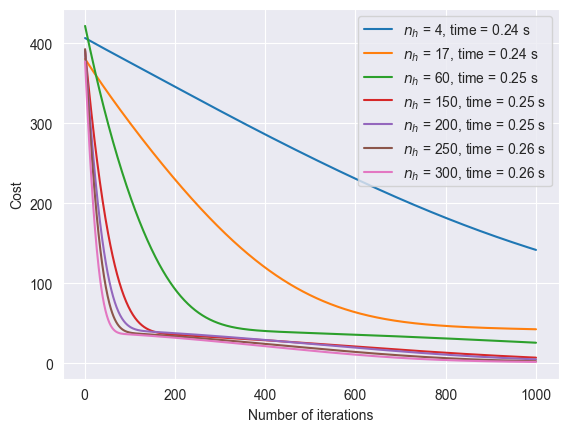

In [111]:
# Define the parameters
input_size = 1      # Dimension of the input (x)
output_size = 1     # Dimension of the output (u)

initial_point_of_the_domain = 0 # x in (a,b)
last_point_of_the_domain = 1
number_of_time_steps = 11

number_of_iterations = np.linspace(1, 1000, 1000)

initial_value = 0 # f(a) = initial_value
T0 = initial_value
k = 2
A = 10
H = [4, 17, 60, 150, 200, 250, 300]  # different sizes for the hidden layer
 
fig, ax = plt.subplots()
for h in H:
    loss_per_iter = []
    hidden_size = h   # Number of units in the hidden layer
    
    # Create an instance of the PINN model
    model = PINN_1layer(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

    # Define the collocation points
    x_collocation = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1) # domain (0,1) - 11 sample points as in article

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # in article lr=0.001 as well

    start_time = time.time()  # start time
    
    # Training loop
    num_epochs = 1000 # in article - max 100 iter before convergance
    for epoch in range(num_epochs):
        # Zero the gradients
        optimizer.zero_grad()

        # Compute the loss
        loss = pinn_loss(model, x_collocation, k, A, T0)

        # Perform optimization
        loss.backward()
        optimizer.step()
        
        loss_per_iter.append(loss.item())  # loss after each iteration
        
    end_time = time.time()
    total_time = end_time - start_time
    
    print(round(loss_per_iter[-1],4))

    plt.plot(number_of_iterations, loss_per_iter, label=r'$n_h$ = {}, time = {} s'.format(h, '{:.2f}'.format(total_time)))

plt.legend()
#plt.title('Convergence of cost function for different number of neurons')
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.grid(True)
plt.show()
#fig.savefig('graphs/convergence_different_number_of_neurons_Newton.pdf')

## Experiment number of layers

In [106]:
# Define the neural network model
class PINN_2layers(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, initial_value, initial_point_of_the_domain):
        super(PINN_2layers, self).__init__() # getting acess to all things from nn.Module
        self.initial_value = initial_value
        self.initial_point_of_the_domain = initial_point_of_the_domain
        
        self.layer1 = nn.Linear(input_size, hidden_size1)  # Define the input layer
        self.layer2 = nn.Linear(hidden_size1, hidden_size2) # Define the hidden layer
        self.layer3 = nn.Linear(hidden_size2, output_size) # Define the output layer

    def forward(self, x):
        x_ = torch.sigmoid(self.layer1(x))  # Apply sigmoid activation to the hidden layer
        x_ = torch.sigmoid(self.layer2(x_))
        x_ = self.layer3(x_)
        
        x_ = self.initial_value + (x-self.initial_point_of_the_domain)*x_
        return x_

138.2822
32.1118
203.9277
21.4914


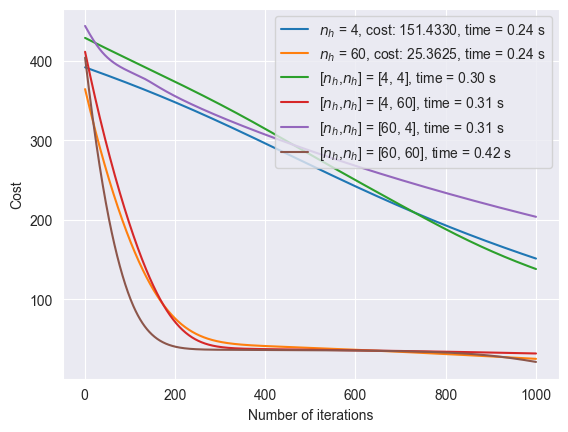

In [112]:
# Define the parameters
input_size = 1      # Dimension of the input (x)
output_size = 1     # Dimension of the output (u)

initial_point_of_the_domain = 0 # x in (a,b)
last_point_of_the_domain = 1
number_of_time_steps = 11

initial_value = 0 # f(a) = initial_value
T0 = initial_value
k = 2
A = 10
H = [4, 60]  # different sizes for the hidden
H1 = [4, 60]  # different sizes for the first hidden layer
H2 = [4, 60]  # different sizes for the second hidden layer
number_of_iterations = np.linspace(1, 1000, 1000)

fig, ax = plt.subplots()
for h in H:
    loss_per_iter = []
    hidden_size = h   # Number of units in the hidden layer
    
    # Create an instance of the PINN model
    model = PINN_1layer(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

    # Define the collocation points
    x_collocation = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1) # domain (0,1) - 11 sample points as in article

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # in article lr=0.001 as well

    start_time = time.time()  # start time
    
    # Training loop
    num_epochs = 1000 # in article - max 100 iter before convergance
    for epoch in range(num_epochs):
        # Zero the gradients
        optimizer.zero_grad()

        # Compute the loss
        loss = pinn_loss(model, x_collocation, k, A, T0)

        # Perform optimization
        loss.backward()
        optimizer.step()
        
        loss_per_iter.append(loss.item())  # loss after each iteration
        
    end_time = time.time()
    total_time = end_time - start_time

    plt.plot(number_of_iterations, loss_per_iter, label=r'$n_h$ = {}, cost: {}, time = {} s'.format(h, '{:.4f}'.format(loss_per_iter[-1]), '{:.2f}'.format(total_time)))
    
for h1 in H1:
    for h2 in H2:

        loss_per_iter = []
        hidden_size1 = h1   # Number of units in the 1st hidden layer
        hidden_size2 = h2  # Number of units in the 2nd hidden layer

        # Create an instance of the PINN model
        model = PINN_2layers(input_size, hidden_size1, hidden_size2, output_size, initial_value, initial_point_of_the_domain)

        # Define the collocation points
        x_collocation = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1) # domain (0,1) - 11 sample points as in article 

        # Define the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        start_time = time.time()  # start time

        # Training loop
        num_epochs = 1000 # as in article - max 100 iter
        for epoch in range(num_epochs):
            # Zero the gradients
            optimizer.zero_grad()

            # Compute the loss
            loss = pinn_loss(model, x_collocation, k, A, T0)

            # Perform optimization
            loss.backward()
            optimizer.step()

            loss_per_iter.append(loss.item())  # loss after each iteration

        end_time = time.time()
        total_time = end_time - start_time
        print(round(loss_per_iter[-1],4))
        plt.plot(number_of_iterations, loss_per_iter, label=r'[$n_h$,$n_h$] = {}, time = {} s'.format([h1, h2], '{:.2f}'.format(total_time)))
        
plt.legend()
#plt.title('Convergence of cost function for different network architectures')
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.grid(True)
plt.show()
#fig.savefig('graphs/convergence_different_number_of_layers_Newton.pdf')

## Implementation and comparison with analytical and RK4 solution

In [84]:
# Define the parameters
input_size = 1      # Dimension of the input (x)
hidden_size = 60   # Number of units in the hidden layer
output_size = 1     # Dimension of the output (u)

initial_point_of_the_domain = 0 # x in (a,b)
last_point_of_the_domain = 1
number_of_time_steps = 11

initial_value = 0 # f(a) = initial_value
T0 = initial_value
k = 2
A = 10

# Create an instance of the PINN model
model = PINN_1layer(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

# Define the collocation points
x_collocation = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1) # domain (0,1) - 11 sample points as in article 

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # in article lr=0.001 as well

# Training loop
num_epochs = 3000 # as in the article
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Compute the loss
    loss = pinn_loss(model, x_collocation, k, A, T0)

    # Perform optimization
    loss.backward()
    optimizer.step()

# Evaluate the trained model
with torch.no_grad():
    # Generate test data
    x_test = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1)

    # Convert test data to PyTorch tensor
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    # Compute the neural network's predictions
    u_pred_tensor = model(x_test_tensor)

# Compute the analytic solution for comparison
u_analytic = analytic_solution(x_test_tensor, k, A, T0)

In [85]:
# RK solution - numeric
# Solve ODE using Runge-Kutta 4 (solve_ivp from scipy)
tf = last_point_of_the_domain   # Final time
    
sol = solve_ivp(fun=lambda t, y: ode_function(y, k, A),
                t_span=(initial_point_of_the_domain, tf),
                y0=[T0],
                method='RK45',
                t_eval=np.linspace(initial_point_of_the_domain, tf, 11))

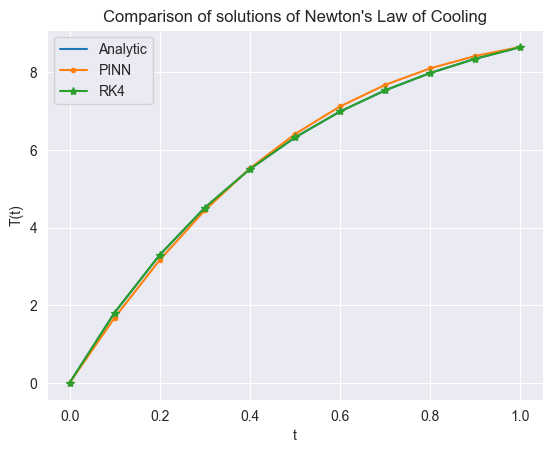

In [86]:
plt.plot(x_collocation, u_analytic, label='Analytic')
plt.plot(x_collocation, u_pred, label='PINN', marker=".")
plt.plot(sol.t, sol.y[0], label='RK4', marker='*')
plt.title("Comparison of solutions of Newton's Law of Cooling")
plt.xlabel('t')
plt.ylabel('T(t)')
plt.grid(True)
plt.legend() 
plt.show()

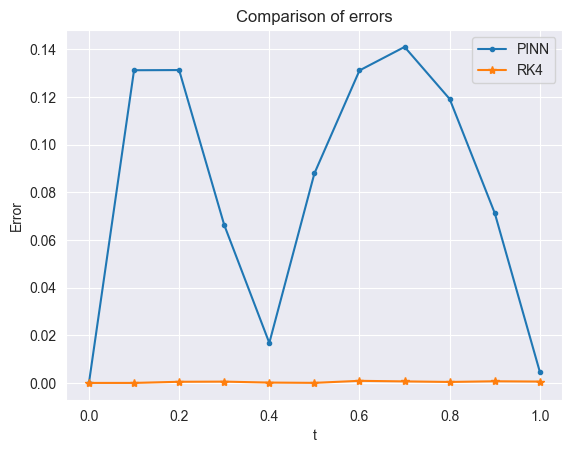

In [87]:
plt.plot(x_collocation, np.abs(torch.Tensor(u_pred) - u_analytic), marker='.', label='PINN')
plt.plot(sol.t, abs(sol.y[0]-[element for sublist in u_analytic for element in sublist]), marker='*', label='RK4')
plt.legend()
plt.title('Comparison of errors')
plt.xlabel('t')
plt.ylabel('Error')
plt.grid(True)
plt.show()

## Grid effect RK4 vs ANN

Error of RK4 for Newton Law of Cooling for 11 grid: 0.000
Error of PINN for Newton Law of Cooling for 11 grid: 0.076
Error of RK4 for Newton Law of Cooling for 16 grid: 0.000
Error of PINN for Newton Law of Cooling for 16 grid: 0.087
Error of RK4 for Newton Law of Cooling for 21 grid: 0.000
Error of PINN for Newton Law of Cooling for 21 grid: 0.086
Error of RK4 for Newton Law of Cooling for 26 grid: 0.000
Error of PINN for Newton Law of Cooling for 26 grid: 0.091


/var/folders/gx/5fq598cs4qb1zn8jlnpd4hym0000gn/T/ipykernel_3724/3235544396.py:92: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


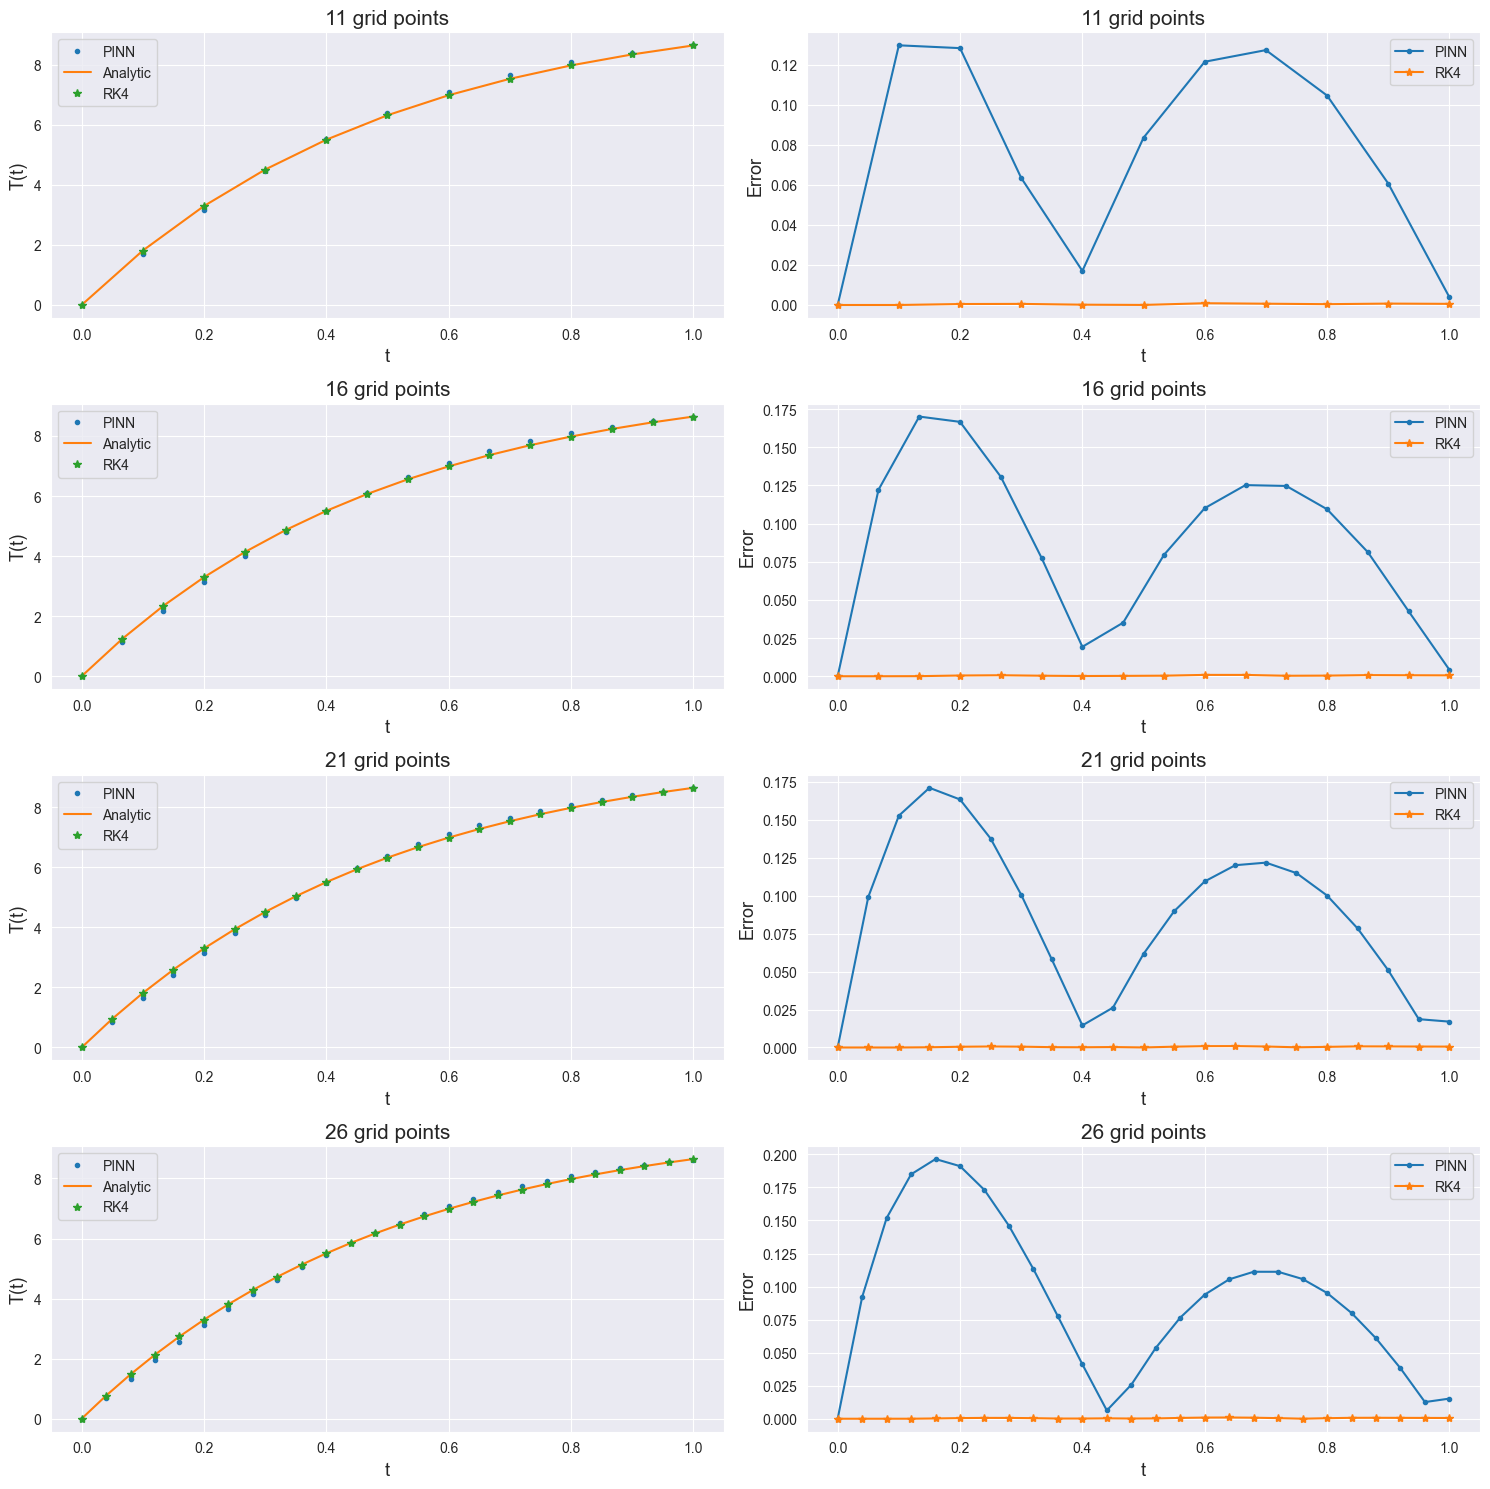

In [113]:
# diffent size of grid points between a and b.
M = [11, 16, 21, 26]
# Define the parameters
input_size = 1      # Dimension of the input (x)
hidden_size = 60   # Number of units in the hidden layer
output_size = 1     # Dimension of the output (u)

initial_point_of_the_domain = 0 # x in (a,b)
last_point_of_the_domain = 1

initial_value = 0 # f(a) = initial_value
T0 = initial_value
k = 2
A = 10

fig, axs = plt.subplots(4, 2, figsize=(15, 15))
for ind, m in enumerate(M):
    
    # NN
    # Create an instance of the PINN model
    model = PINN_1layer(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

    # Define the collocation points
    x_collocation = np.linspace(initial_point_of_the_domain, last_point_of_the_domain, m).reshape(-1, 1) # domain (0,1) - m sample points as in article

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # in article lr=0.001 as well

    # Training loop
    num_epochs = 3000 # as in the article
    for epoch in range(num_epochs):
        # Zero the gradients
        optimizer.zero_grad()

        # Compute the loss
        loss = pinn_loss(model, x_collocation, k, A, T0)

        # Perform optimization
        loss.backward()
        optimizer.step()

    # Evaluate the trained model
    with torch.no_grad():
        # Generate test data
        x_test = np.linspace(initial_point_of_the_domain, last_point_of_the_domain, m).reshape(-1, 1)

        # Convert test data to PyTorch tensor
        x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

        # Compute the neural network's predictions
        u_pred_tensor = model(x_test_tensor)

        # Convert predictions to numpy array
        u_pred = u_pred_tensor.numpy()

    # Compute the analytic solution for comparison
    u_analytic = analytic_solution(x_test_tensor, k, A, T0)

    axs[ind,0].plot(x_collocation, u_pred, '.', label='PINN')
    axs[ind,0].plot(x_collocation, u_analytic, label='Analytic')


    # RK solution - numeric
    # Solve ODE using Runge-Kutta 4 (solve_ivp from scipy)
    tf = last_point_of_the_domain   # Final time

    sol = solve_ivp(fun=lambda t, y: ode_function(y, k, A),
                    t_span=(initial_point_of_the_domain, tf),
                    y0=[T0],
                    method='RK45',
                    t_eval=np.linspace(initial_point_of_the_domain, tf, m))
    axs[ind,0].plot(sol.t, sol.y[0], '*', label='RK4')
    axs[ind,0].legend()
    axs[ind,0].set_title("{} grid points".format(m), 
                         fontsize=15)
    axs[ind,0].set_xlabel('t', fontsize=13)
    axs[ind,0].set_ylabel('T(t)', fontsize=13)

    axs[ind,1].plot(x_collocation, abs(torch.Tensor(u_pred)-u_analytic), label='PINN', marker='.')
    axs[ind,1].plot(sol.t, abs(sol.y[0]-[element for sublist in u_analytic for element in sublist]), label='RK4', marker='*')
    axs[ind,1].legend()
    axs[ind,1].set_title("{} grid points".format(m),
                        fontsize=15)
    axs[ind,1].set_xlabel('t', fontsize=13)
    axs[ind,1].set_ylabel('Error', fontsize=13)
    # MAE
    mae_rk4 = mae(sol.y[0], u_analytic)
    print(f'Error of RK4 for Newton Law of Cooling for {m} grid: {mae_rk4:.3f}')
    mae_pinn = mae(u_pred, u_analytic)
    print(f'Error of PINN for Newton Law of Cooling for {m} grid: {mae_pinn:.3f}' )
fig.tight_layout()
fig.show()
#fig.savefig('graphs/PINN_Newton_different_grid.pdf')

## For different activation functions

In [114]:
# Define the neural network model
class PINN_1layer_relu(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain):
        super(PINN_1layer_relu, self).__init__() # getting acess to all things from nn.Module
        self.initial_value = initial_value
        self.initial_point_of_the_domain = initial_point_of_the_domain
        
        self.layer1 = nn.Linear(input_size, hidden_size)  # Define the input layer
        self.layer2 = nn.Linear(hidden_size, output_size) # Define the output layer

    def forward(self, x):
        x_ = torch.relu(self.layer1(x))  # Apply sigmoid activation to the hidden layer
        x_ = self.layer2(x_)               # Output layer - no activation function
        x_ = self.initial_value + (x-self.initial_point_of_the_domain)*x_
        return x_

In [115]:
# Define the neural network model
class PINN_1layer_leaky_relu(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain):
        super(PINN_1layer_leaky_relu, self).__init__() # getting acess to all things from nn.Module
        self.initial_value = initial_value
        self.initial_point_of_the_domain = initial_point_of_the_domain
        
        self.layer1 = nn.Linear(input_size, hidden_size)  # Define the input layer
        self.layer2 = nn.Linear(hidden_size, output_size) # Define the output layer

    def forward(self, x):
        x_ = F.leaky_relu(self.layer1(x))  # Apply sigmoid activation to the hidden layer
        x_ = self.layer2(x_)               # Output layer - no activation function
        x_ = self.initial_value + (x-self.initial_point_of_the_domain)*x_
        return x_

In [116]:
# Define the parameters
input_size = 1      # Dimension of the input (x)
hidden_size = 60   # Number of units in the hidden layer
output_size = 1     # Dimension of the output (u)

initial_point_of_the_domain = 0 # x in (a,b)
last_point_of_the_domain = 1
number_of_time_steps = 11

initial_value = 0 # f(a) = initial_value
T0 = initial_value
k = 2
A = 10


# Create an instance of the PINN model
model = PINN_1layer(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

# Define the collocation points
x_collocation = np.linspace(initial_point_of_the_domain, 
                                    last_point_of_the_domain, number_of_time_steps).reshape(-1, 1) # domain (0,1) - 11 sample points as in article

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # in article lr=0.001 as well

# Training loop
num_epochs = 3000 # as in the article
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Compute the loss
    loss, unsupervised_error_per_epoch = pinn_loss(model, x_collocation, k, A, T0, unsupervised_error=True)

    # Perform optimization
    loss.backward()
    optimizer.step()

# Evaluate the trained model
with torch.no_grad():
    # Generate test data
    x_test = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1)

    # Convert test data to PyTorch tensor
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    # Compute the neural network's predictions
    u_pred_tensor = model(x_test_tensor)

    # Convert predictions to numpy array
    u_pred = u_pred_tensor.numpy()

In [117]:
# Define the parameters
input_size = 1      # Dimension of the input (x)
hidden_size = 60   # Number of units in the hidden layer
output_size = 1     # Dimension of the output (u)

initial_point_of_the_domain = 0 # x in (a,b)
last_point_of_the_domain = 1
number_of_time_steps = 11

initial_value = 0 # f(a) = initial_value
T0 = initial_value
k = 2
A = 10

# Create an instance of the PINN model
model = PINN_1layer_relu(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

# Define the collocation points
x_collocation = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1) # domain (0,1) - 11 sample points as in article

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # in article lr=0.001 as well

# Training loop
num_epochs = 3000 # as in the article
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Compute the loss
    loss, unsupervised_error_relu_per_epoch = pinn_loss(model, x_collocation, k, A, T0, unsupervised_error=True)

    # Perform optimization
    loss.backward()
    optimizer.step()

# Evaluate the trained model
with torch.no_grad():
    # Generate test data
    x_test = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1)

    # Convert test data to PyTorch tensor
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    # Compute the neural network's predictions
    u_pred_relu_tensor = model(x_test_tensor)

    # Convert predictions to numpy array
    u_pred_relu = u_pred_tensor.numpy()

In [118]:
# Define the parameters
input_size = 1      # Dimension of the input (x)
hidden_size = 60   # Number of units in the hidden layer
output_size = 1     # Dimension of the output (u)

initial_point_of_the_domain = 0 # x in (a,b)
last_point_of_the_domain = 1
number_of_time_steps = 11

initial_value = 0 # f(a) = initial_value
T0 = initial_value
k = 2
A = 10

# Create an instance of the PINN model
model = PINN_1layer_leaky_relu(input_size, hidden_size, output_size, initial_value, initial_point_of_the_domain)

# Define the collocation points
x_collocation = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1) # domain (0,1) - 11 sample points as in article

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # in article lr=0.001 as well

# Training loop
num_epochs = 3000 # as in the article
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Compute the loss
    loss, unsupervised_error_leaky_relu_per_epoch = pinn_loss(model, x_collocation, k, A, T0, unsupervised_error=True)

    # Perform optimization
    loss.backward()
    optimizer.step()

# Evaluate the trained model
with torch.no_grad():
    # Generate test data
    x_test = np.linspace(initial_point_of_the_domain, 
                                last_point_of_the_domain, number_of_time_steps).reshape(-1, 1)

    # Convert test data to PyTorch tensor
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

    # Compute the neural network's predictions
    u_pred_leaky_relu_tensor = model(x_test_tensor)

    # Convert predictions to numpy array
    u_pred_leaky_relu = u_pred_tensor.numpy()

In [119]:
# Compute the analytic solution for comparison
u_analytic = analytic_solution(x_test_tensor, k, A, T0)

In [120]:
# MAE
mae_pinn_sigmoid = mae(u_pred, u_analytic)
mae_pinn_relu = mae(u_pred_relu, u_analytic)
mae_pinn_leaky_relu = mae(u_pred_leaky_relu, u_analytic)
print(f'Error of PINN for Newton Law of Cooling for sigmoid activation function: {mae_pinn_sigmoid:.3f}' )
print(f'Error of PINN for Newton Law of Cooling for ReLU activation function: {mae_pinn_relu:.3f}' )
print(f'Error of PINN for Newton Law of Cooling for leaky ReLU activation function: {mae_pinn_leaky_relu:.3f}' )

Error of PINN for Newton Law of Cooling for sigmoid activation function: 0.076
Error of PINN for Newton Law of Cooling for ReLU activation function: 0.076
Error of PINN for Newton Law of Cooling for leaky ReLU activation function: 0.076


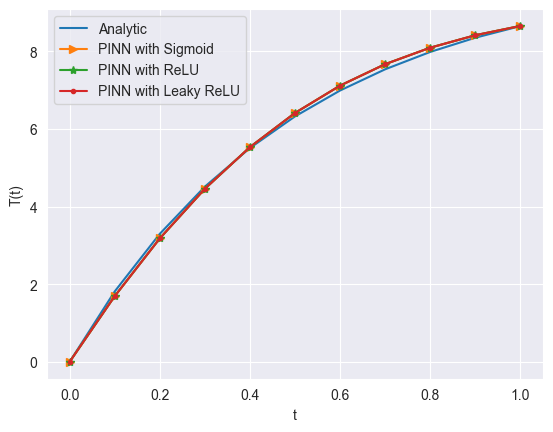

In [121]:
fig, axs = plt.subplots()
plt.plot(x_collocation, u_analytic, label='Analytic')
plt.plot(x_collocation, u_pred, label='PINN with Sigmoid', marker='>')
plt.plot(x_collocation, u_pred_relu, label='PINN with ReLU', marker='*')
plt.plot(x_collocation, u_pred_leaky_relu, label='PINN with Leaky ReLU', marker='.')
#plt.title("Comparison of solutions of Newton's Law of Cooling of different PINNs")
plt.xlabel('t')
plt.ylabel('T(t)')
plt.legend()
plt.show()
#fig.savefig('graphs/PINN_Newton_solutions_different_activation_functions.pdf')

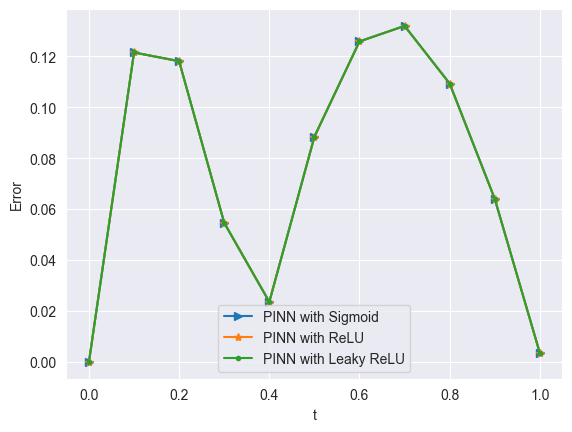

In [122]:
fig, axs = plt.subplots()
plt.plot(x_collocation, abs(torch.Tensor(u_pred)-u_analytic), label='PINN with Sigmoid', marker='>')
plt.plot(x_collocation, abs(torch.Tensor(u_pred_relu)-u_analytic), label='PINN with ReLU', marker="*")
plt.plot(x_collocation, abs(torch.Tensor(u_pred_leaky_relu)-u_analytic), label='PINN with Leaky ReLU', marker=".")
#plt.title("Comparison of errors of Newton's Law of Cooling of different PINNs")
plt.xlabel('t')
plt.ylabel('Error')
plt.legend()
plt.show()
#fig.savefig('graphs/PINN_Newton_errors_different_activation_functions.pdf')